# Analyzing Popular Android & iOS Apps

In this project, I will analyze usage data from 17,000+ apps on the Google Play and Apple iOS App Stores, to understand what types of apps are likely to attract the most users.

Datasets used:
- Android app data from the Google Play store: [link](https://dq-content.s3.amazonaws.com/350/googleplaystore.csv)
- iOS data from the Apple App Store: [link](https://dq-content.s3.amazonaws.com/350/AppleStore.csv)

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load the data

First, I load the data. I create a function to load each dataset from its respective URL as a list of lists:

In [2]:
def load_data_from_url(url):
    df = pd.read_csv(url)
    a = df.columns.values.tolist()  # column row
    b = df.values.tolist()  # body rows
    b.insert(0, a)  # add column row as first element of list
    return b

I use this function to load each dataset:

In [3]:
data_android = load_data_from_url('https://dq-content.s3.amazonaws.com/350/googleplaystore.csv')
data_ios = load_data_from_url('https://dq-content.s3.amazonaws.com/350/AppleStore.csv')

## Explore the data

Next, I define a function to explore each dataset. This function returns a slice of a given dataset, taking several parameters:

- `dataset`: dataset of interest, as a list of lists
- `start`, `end`: start and end integer indices of desired slice from the dataset
- `rows_and_columns`: boolean indicating whether to return number of rows and columns in the dataset

In [4]:
def explore_data(dataset, start, end, rows_and_columns=False):
    for row in dataset[start:end]:
        print(row)
        print('\n')
    if rows_and_columns:
        print('Number of rows: ', len(dataset))
        print('Number of columns: ', len(dataset[0]))

Now I use this function to preview the first 2 rows of each dataset:

In [5]:
# preview android app data
print(explore_data(data_android, 0, 2, rows_and_columns=True))

['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']


['Photo Editor & Candy Camera & Grid & ScrapBook', 'ART_AND_DESIGN', 4.1, '159', '19M', '10,000+', 'Free', '0', 'Everyone', 'Art & Design', 'January 7, 2018', '1.0.0', '4.0.3 and up']


Number of rows:  10842
Number of columns:  13
None


In [6]:
# preview iOS app data
print(explore_data(data_ios, 0, 2, rows_and_columns=True))

['id', 'track_name', 'size_bytes', 'currency', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ver', 'cont_rating', 'prime_genre', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic']


[284882215, 'Facebook', 389879808, 'USD', 0.0, 2974676, 212, 3.5, 3.5, '95.0', '4+', 'Social Networking', 37, 1, 29, 1]


Number of rows:  7198
Number of columns:  16
None


As expected, the first row of each dataset correctly contains the column names. We have data from more than 17000 apps, and the data includes metrics on app ratings, price, genre and more.

## Clean the data

### Removing incorrect data

Next, we remove incorrect data; specifically, there was one row in the Google Play store data that had an invalid entry for the `Reviews` column (see discussion [here](https://www.kaggle.com/lava18/google-play-store-apps/discussion/66015)). Specifically, in this row, the review value couldn't be converted to a `float`. So we check for rows where that could be the case and delete accordingly:

In [7]:
for i, row in enumerate(data_android[1:]):
    try: 
        float(row[3])
    except:
        print('Could not convert string to float for row with index: ' + str(i))
        index_to_del = i+1  # +1 accounts for missing header

Could not convert string to float for row with index: 10472


In [8]:
del data_android[index_to_del]

### Removing duplicates

We first identify cases where an app appears more than once:

In [9]:
duplicate_apps = []
unique_apps = []

# build list of unique and duplicate app names
for row in data_android[1:]:
    app_name = row[0]
    if app_name in unique_apps:
        duplicate_apps.append(app_name)
    else:
        unique_apps.append(app_name)   
        
# print the number of duplicates
print('Identified ' + str(len(duplicate_apps)) + ' duplicate app names...')

Identified 1181 duplicate app names...


Taking a look at one of these duplicate cases, we can see that they are identical apart from the column indicating number of reviews, likely because the entries occurred at different points in time:

In [10]:
duplicate_apps[7]
for row in data_android[1:]:
    if row[0] == duplicate_apps[7]:
        print(row)

['Google Ads', 'BUSINESS', 4.3, '29313', '20M', '5,000,000+', 'Free', '0', 'Everyone', 'Business', 'July 30, 2018', '1.12.0', '4.0.3 and up']
['Google Ads', 'BUSINESS', 4.3, '29313', '20M', '5,000,000+', 'Free', '0', 'Everyone', 'Business', 'July 30, 2018', '1.12.0', '4.0.3 and up']
['Google Ads', 'BUSINESS', 4.3, '29331', '20M', '5,000,000+', 'Free', '0', 'Everyone', 'Business', 'July 30, 2018', '1.12.0', '4.0.3 and up']


So we decide to keep only the row with the highest number of reviews for each duplicate. To do this, we create a dictionary containing each unique app name and its highest number of recorded reviews:

In [11]:
reviews_max = {}
for row in data_android[1:]:
    app_name = row[0]
    n_reviews = float(row[3])
    if app_name in reviews_max:
        if n_reviews > reviews_max[app_name]:
            reviews_max[app_name] = n_reviews
    else:
        reviews_max[app_name] = n_reviews

# number of non-duplicate entries
print(len(reviews_max))

9659


We can now use this dictionary to remove duplicate rows, keeping rows with the highest number of ratings per app:

In [12]:
android_clean = []
already_added = []
for row in data_android[1:]:
    app_name = row[0]
    n_reviews = float(row[3])
    
    # if number of reviews is equal to max reviews
    # and app is not in already_added list
    if n_reviews == reviews_max[app_name] and app_name not in already_added:
        android_clean.append(row)
        already_added.append(app_name)
        
# show preview of cleaned data
print(android_clean[:2])

[['Photo Editor & Candy Camera & Grid & ScrapBook', 'ART_AND_DESIGN', 4.1, '159', '19M', '10,000+', 'Free', '0', 'Everyone', 'Art & Design', 'January 7, 2018', '1.0.0', '4.0.3 and up'], ['U Launcher Lite – FREE Live Cool Themes, Hide Apps', 'ART_AND_DESIGN', 4.7, '87510', '8.7M', '5,000,000+', 'Free', '0', 'Everyone', 'Art & Design', 'August 1, 2018', '1.2.4', '4.0.3 and up']]


We can also check if there are duplicates in the iOS app data, and we see that there are 0:

In [13]:
duplicate_apps = []
unique_apps = []

# build list of unique and duplicate app names
for row in data_ios[1:]:
    app_name = row[0]
    if app_name in unique_apps:
        duplicate_apps.append(app_name)
    else:
        unique_apps.append(app_name)
        
# print the number of duplicates
print('Identified ' + str(len(duplicate_apps)) + ' duplicate app names...')

Identified 0 duplicate app names...


## Filter the data

### Removing non-English apps

To filter to include apps designed for an English-speaking audience, we need to remove apps containing characters not commonly used in English text. We do this by creating a function that checks a string for such characters, and then apply that function:

In [14]:
def is_english(a_string):
    for char in a_string:
        if ord(char) > 127:
            return False
    return True

# check that the function works
print(is_english('Instagram'))
print(is_english('Docs To Go™ Free Office Suite'))
print(is_english('Instachat 😜'))

True
False
False


We can see that emojis and the trademark symbol are marked as characters not commonly used in English. Therefore, we apply the following criterion to remove apps: all apps with 3 or more non-English characters are removed. We update the function accordingly:

In [15]:
def is_english(a_string):
    tally = 0
    for char in a_string:
        if ord(char) > 127:
            tally += 1
    
    if tally >= 3:
        return False
    else:
        return True
    
# check that the updated function works
print(is_english('Instagram'))
print(is_english('Docs To Go™ Free Office Suite'))
print(is_english('Instachat 😜'))

True
True
True


And then we apply the function to each dataset, creating a new list of lists for each dataset containing only app names with characters common in English text:

In [16]:
# apply function to android data:
android_filt = []
for row in android_clean:
    app_name = row[0]
    if is_english(app_name):
        android_filt.append(row)
        
print('Number of entries in filtered Android app data: ' + str(len(android_filt)))

Number of entries in filtered Android app data: 9597


In [17]:
# apply function to iOS data:
ios_filt = []
for row in data_ios:
    app_name = row[1]
    if is_english(app_name):
        ios_filt.append(row)
        
print('Number of entries in filtered iOS app data: ' + str(len(ios_filt)))

Number of entries in filtered iOS app data: 6156


### Removing non-free apps

In addition, we only want to examine free apps. To remove apps that are not free from each dataset, we find rows where the app price is 0, and create new datasets with only those rows:

In [18]:
# only include free apps from android data
android_free = []
for row in android_filt:
    # in android data, prices are strings with $
    # so this step removes the $
    price = row[7].replace('$', '')
    price = float(price)
    if price == 0:
        android_free.append(row)
        
print('Number of entries in final Android app data: ' + str(len(android_free)))

Number of entries in final Android app data: 8848


In [19]:
# only include free apps from iOS data
ios_free = []
for row in ios_filt:
    # in iOS data, prices are already floats
    price = row[4]
    if price == 0:
        ios_free.append(row)
        
print('Number of entries in final iOS app data: ' + str(len(ios_free)))

Number of entries in final iOS app data: 3203


## Identifying the most common apps by genre and category

Our goal is to create an app that is successful in both the Android and iOS app markets. We can start by determining the most common genres for each market. 

Specifically, for the Android app data, we will build frequency tables showing the frequency of each `category` and `genre`. For the iOS data, we will build a frequency table shwoing the frequency of each `prime_genre`:

In [20]:
# function to create a frequency table
def freq_table(dataset, index):
    freq_dict = {}
    for row in dataset:
        element = row[index]
        if element in freq_dict:
            freq_dict[element] += 1
        else:
            freq_dict[element] = 1
    
    return freq_dict

In [21]:
# create frequency table for android apps, category
android_freq_category = freq_table(android_free, 1)

# create frequency table for android apps, genre
android_freq_genre = freq_table(android_free, 9)

In [22]:
# create frequency table for iOS apps, prime_genre
ios_freq_genre = freq_table(ios_free, 11)

Next, we can visualize these frequencies, first defining a function to visualize the frequency tables as barplots, arranged in order of decreasing frequency:

In [23]:
# function to visualize frequency table
def plot_freq_table(d, title, height = 13):
    
    # sort dictionary in descending order of frequency
    d_sorted = sorted(d.items(), key=lambda x:x[1])
    d = dict(d_sorted)
    
    # create vertical barplot
    plt.figure(figsize=(9, height))
    axes = plt.axes()
    axes.get_xaxis().set_visible(False)
    spines = axes.spines
    spines['top'].set_visible(False)
    spines['right'].set_visible(False)
    spines['bottom'].set_visible(False)
    spines['left'].set_visible(False)
    ax = plt.barh(range(len(d)), list(d.values()), height = 0.3)
    plt.yticks(range(len(d)), list(d.keys()))
    plt.xticks(range(4), range(4))

    # show label with value for each bar
    rectangles = ax.patches
    for rectangle in rectangles:
        x_value = rectangle.get_width()
        y_value = rectangle.get_y() + rectangle.get_height() / 2
        space = 5
        ha = 'left'
        label = "{}".format(x_value)
        if x_value > 0:
            plt.annotate(
                label,
                (x_value, y_value),
                xytext=(space, 0),
                textcoords="offset points",
                va='center',
                ha=ha)
            
    # add title and show
    plt.title(title)
    plt.show()

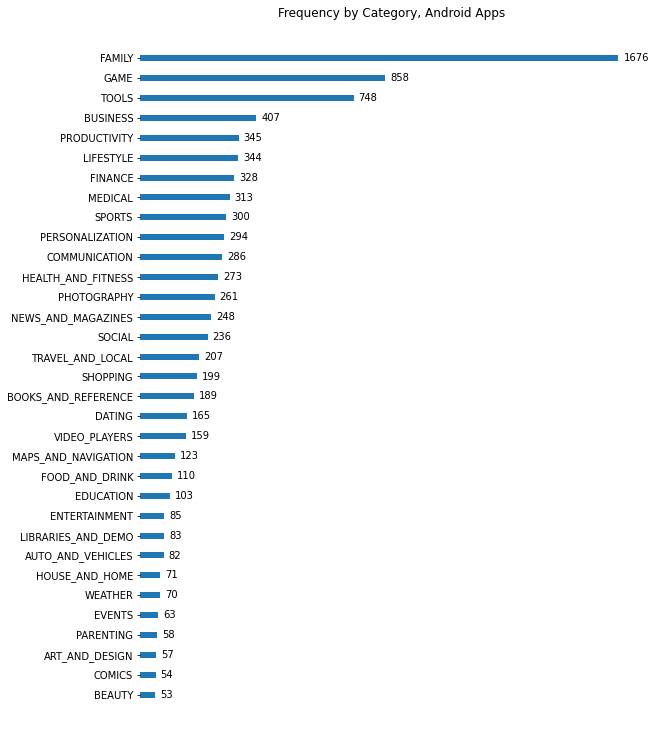

In [24]:
# barplot for android apps, category
plot_freq_table(android_freq_category, 'Frequency by Category, Android Apps')

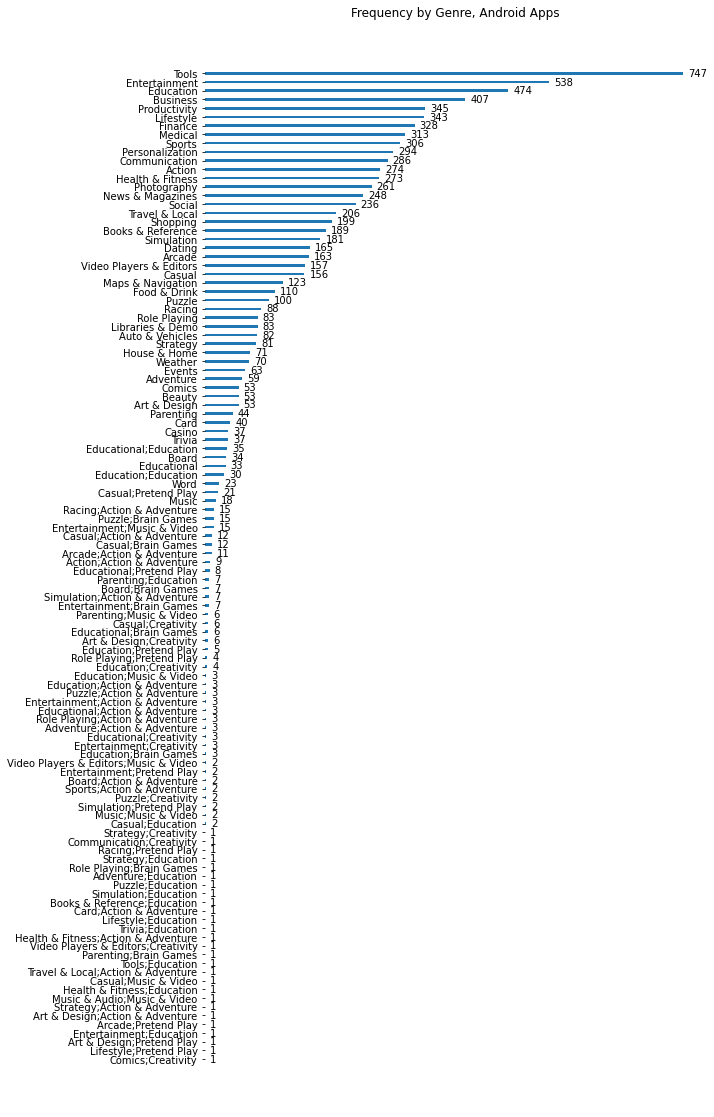

In [25]:
# barplot for android apps, genre
plot_freq_table(android_freq_genre, 'Frequency by Genre, Android Apps', height = 20)

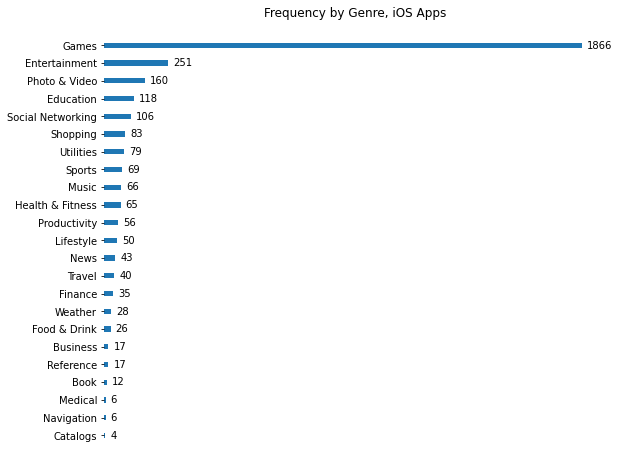

In [26]:
# barplot for iOS apps, prime_genre
plot_freq_table(ios_freq_genre, 'Frequency by Genre, iOS Apps', height = 8)

We can see that for Android apps, the most popular app category was `Family` followed by `Game`, and the most common genres were `Tools` and `Entertainment`. For iOS apps, the most common genre was `Games` followed by `Entertainment`.

This initial look at the data suggests that for the Apple App Store, the majority of apps are designed for entertainment, whereas for the Google Play Store, common apps fall into both the entertainment and tools categories.

## Identifying the most commonly installed apps by genre and category

Next, we can determine which apps are the most popular by calculating the average number of installs for apps in each genre/category. For the Android app dataset, this information is stored in the `Installs` column. For the App Store dataset, there are no direct metrics reflecting number of installs, so we can use `rating_count_tot` as a proxy.

To do so, we first create a function to compute the average number of installs for each genre/category of interest. This function uses the function above which created frequency tables to get a list of unique genres/categories, then calculates the average number of installs for each category. Then we apply the function to each dataset:

In [27]:
# function to create summary table showing average installs/ratings per genre/category
def compute_avg_installs(dataset, index_genre, index_installs, store='Apple'):
    
    # create frequency table to get unique list of genres
    genre_dict = freq_table(dataset, index_genre)
    
    # create empty dictionary to store avg results
    avg_dict = {}
    
    # loop over genres
    for genre in genre_dict:
        total = 0
        len_genre = 0
        
        for row in dataset:
            genre_app = row[index_genre]
            if genre_app == genre:
                
                # Apple app store ratings data are already numeric
                if store == 'Apple':
                    num_installs = row[index_installs]
                    
                # Google app store install data are sometimes strings, e.g. '10,000+'
                if store == 'Google':
                    num_installs = row[index_installs]
                    num_installs = num_installs.replace('+', '')
                    num_installs = num_installs.replace(',', '')
                    num_installs = float(num_installs)
                    
                total += num_installs
                len_genre += 1
        
        # compute average number of installs for this genre
        avg_installs = total/len_genre
        avg_dict[genre] = avg_installs
    
    return avg_dict

In [28]:
# compute average installs for each genre and category of Android apps
android_installs_category = compute_avg_installs(android_free, 1, 5, store='Google')
android_installs_genre = compute_avg_installs(android_free, 9, 5, store='Google')

# compute average total ratings for each genre and category of iOS apps
ios_installs_genre = compute_avg_installs(ios_free, 11, 5, store='Apple')

Finally, we can visualize these summaries as barplots:

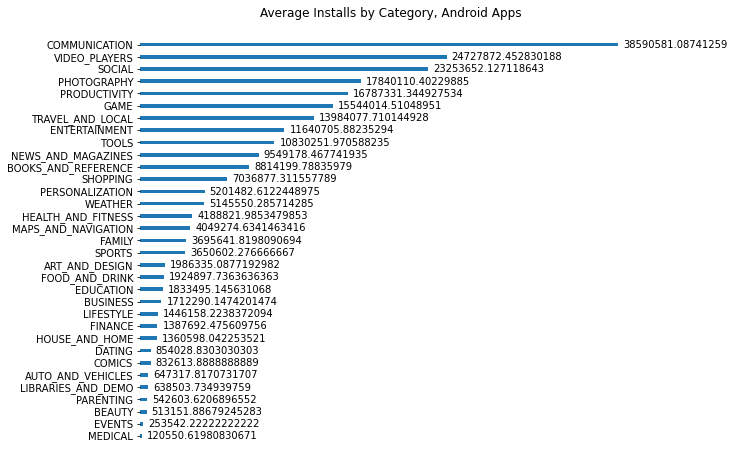

In [29]:
# barplot for android apps, category
plot_freq_table(android_installs_category, 'Average Installs by Category, Android Apps', height = 8)

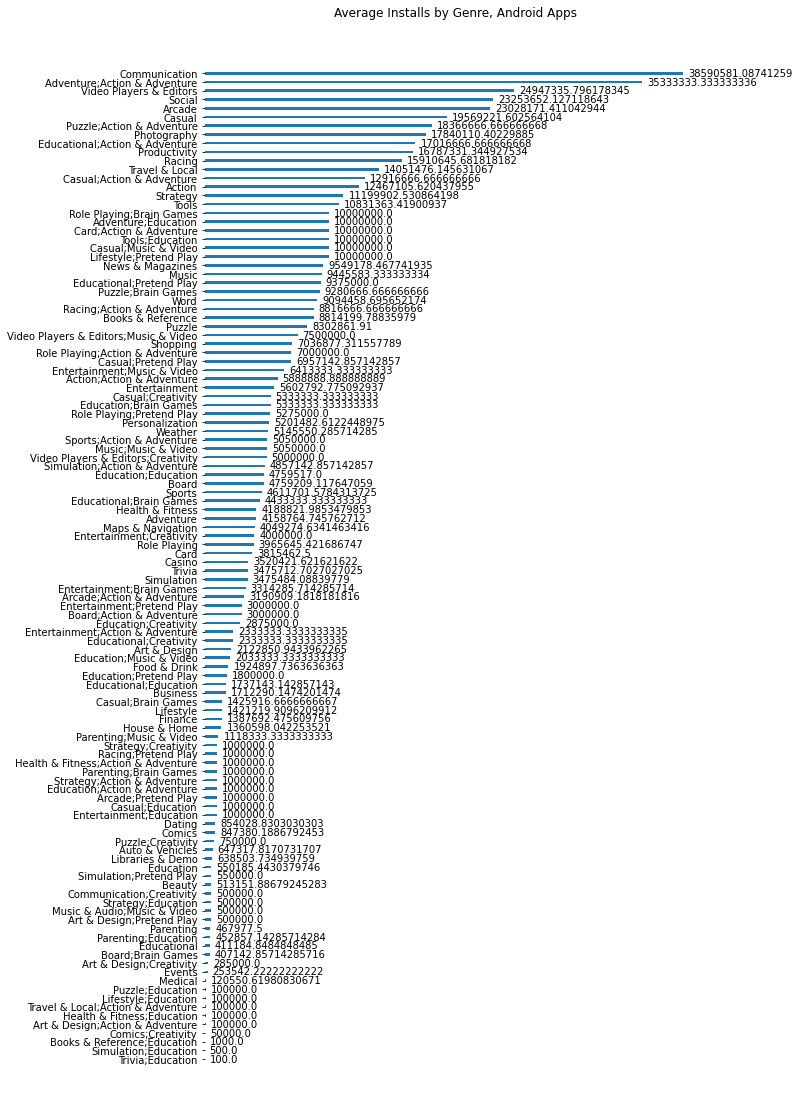

In [30]:
# barplot for android apps, genre
plot_freq_table(android_installs_genre, 'Average Installs by Genre, Android Apps', height = 20)

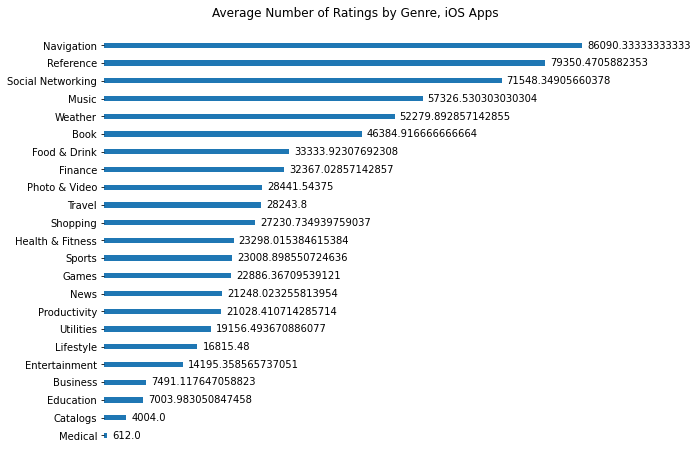

In [31]:
plot_freq_table(ios_installs_genre, 'Average Number of Ratings by Genre, iOS Apps', height = 8)

We can see that the most commonly installed Android apps fell into the categories of communication and video players, and the genres of communication and action/adventure. The iOS apps with the most number of ratings (our proxy for number of installs) came from the navigation and reference genres. 

## Conclusions

In this project, I examined data from thousands of free-to-download apps from each the Apple and Google Play app stores, with the goal of identifying profitable app profiles. 

After cleaning the data - which involved removing duplicates,  non-free apps and those not designed for English speaking audiences - I examined the most abundant apps in terms of category and genre. This indicated that the most common genres were family/entertainment and tools (Google) and games (Apple). When I instead examined which genres/categories by average number of installs per app (likely a better indicator of a more highly-used app), the results looked different: the most commonly installed apps came from the categories of communication (Google/Apple), video players (Google), and action/adventure (Apple).

We can conclude that apps likely to attract the most users will fall into the categories of (a) **communication** (e.g. those allowing users to connect with others users) (b) **video players** (e.g. those allowing users to stream video content) and (c) **adventure/action games**.